In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D,
                                     Flatten, Dense, Dropout, Concatenate, Add,
                                     GlobalAveragePooling2D, Reshape, Multiply)

# Load and preprocess MNIST dataset
data = pd.read_csv("C:\\Users\\HP\\Downloads\\fashion-mnist_test.csv")
X = data.iloc[:, 1:].values / 255.0
y = data.iloc[:, 0].values
X = X.reshape(-1, 28, 28, 1)
y = to_categorical(y, 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Input

def build_lenet5():
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(6, kernel_size=(5,5), activation='tanh', padding='same'),
        AveragePooling2D(pool_size=(2,2)),
        Conv2D(16, kernel_size=(5,5), activation='tanh'),
        AveragePooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(120, activation='tanh'),
        Dense(84, activation='tanh'),
        Dense(10, activation='softmax')
    ])
    return model


# 2. AlexNet
def build_alexnet():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

# 3. GoogLeNet (simplified)
def inception_module(x, f1, f3r, f3, f5r, f5, proj):
    p1 = Conv2D(f1, (1, 1), padding='same', activation='relu')(x)
    p2 = Conv2D(f3r, (1, 1), padding='same', activation='relu')(x)
    p2 = Conv2D(f3, (3, 3), padding='same', activation='relu')(p2)
    p3 = Conv2D(f5r, (1, 1), padding='same', activation='relu')(x)
    p3 = Conv2D(f5, (5, 5), padding='same', activation='relu')(p3)
    p4 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    p4 = Conv2D(proj, (1, 1), padding='same', activation='relu')(p4)
    return Concatenate()([p1, p2, p3, p4])

def build_googlenet():
    input_layer = Input(shape=(28, 28, 1))
    x = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
    x = inception_module(x, 32, 48, 64, 8, 16, 16)
    x = inception_module(x, 64, 64, 96, 16, 48, 32)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(10, activation='softmax')(x)
    return Model(inputs=input_layer, outputs=output)

# 4. VGGNet
def build_vggnet():
    model = Sequential([
        Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(128, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(256, (3,3), padding='same', activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

# 5. ResNet (Mini)
def residual_block(x, filters):
    skip = x
    x = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = Add()([x, skip])
    return tf.keras.activations.relu(x)

def build_resnet():
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(64, (3,3), padding='same', activation='relu')(input_layer)
    x = residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)
    x = residual_block(x, 64)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    return Model(inputs=input_layer, outputs=output)

# 6. Xception (simplified)
def build_xception():
    model = Sequential([
        SeparableConv2D(32, (3,3), activation='relu', padding='same', input_shape=(28,28,1)),
        SeparableConv2D(64, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        SeparableConv2D(128, (3,3), activation='relu', padding='same'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

# 7. SENet (Mini version)
def se_block(x, reduction=16):
    filters = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([x, se])

def build_senet():
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_layer)
    x = se_block(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = se_block(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    return Model(inputs=input_layer, outputs=output)

# Store results and training histories
results = {}
histories = {}

def train_and_evaluate(name, model_fn):
    print(f"\n=== Training {name} ===")
    model = model_fn()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, batch_size=128,
                        validation_data=(X_test, y_test), verbose=2)

    # Store history
    histories[name] = history

    # Predict on test set
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1
    }

    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# Train and evaluate all models
train_and_evaluate("LeNet-5", build_lenet5)
train_and_evaluate("AlexNet", build_alexnet)
train_and_evaluate("GoogLeNet", build_googlenet)
train_and_evaluate("VGGNet", build_vggnet)
train_and_evaluate("ResNet", build_resnet)
train_and_evaluate("Xception", build_xception)
train_and_evaluate("SENet", build_senet)

# Display results
results_df = pd.DataFrame(results).T.sort_values(by="Accuracy", ascending=False)
print("\n📊 Results of All Models (sorted by Accuracy):")
print(results_df)



=== Training LeNet-5 ===
Epoch 1/5
63/63 - 3s - 43ms/step - accuracy: 0.6169 - loss: 1.0888 - val_accuracy: 0.7585 - val_loss: 0.7016
Epoch 2/5
63/63 - 1s - 13ms/step - accuracy: 0.7590 - loss: 0.6600 - val_accuracy: 0.8005 - val_loss: 0.5823
Epoch 3/5
63/63 - 1s - 21ms/step - accuracy: 0.7828 - loss: 0.5894 - val_accuracy: 0.8040 - val_loss: 0.5520
Epoch 4/5
63/63 - 1s - 12ms/step - accuracy: 0.8077 - loss: 0.5416 - val_accuracy: 0.8050 - val_loss: 0.5181
Epoch 5/5
63/63 - 1s - 21ms/step - accuracy: 0.8246 - loss: 0.5008 - val_accuracy: 0.8330 - val_loss: 0.4805
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LeNet-5 - Accuracy: 0.8330, Precision: 0.8338, Recall: 0.8342, F1-score: 0.8324

=== Training AlexNet ===


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
63/63 - 16s - 253ms/step - accuracy: 0.5074 - loss: 1.2742 - val_accuracy: 0.7525 - val_loss: 0.6566
Epoch 2/5
63/63 - 20s - 319ms/step - accuracy: 0.7386 - loss: 0.6855 - val_accuracy: 0.7990 - val_loss: 0.5198
Epoch 3/5
63/63 - 14s - 218ms/step - accuracy: 0.8108 - loss: 0.5202 - val_accuracy: 0.8340 - val_loss: 0.4477
Epoch 4/5
63/63 - 14s - 221ms/step - accuracy: 0.8430 - loss: 0.4375 - val_accuracy: 0.8550 - val_loss: 0.3872
Epoch 5/5
63/63 - 14s - 220ms/step - accuracy: 0.8659 - loss: 0.3706 - val_accuracy: 0.8700 - val_loss: 0.3776
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
AlexNet - Accuracy: 0.8700, Precision: 0.8716, Recall: 0.8700, F1-score: 0.8659

=== Training GoogLeNet ===
Epoch 1/5
63/63 - 46s - 731ms/step - accuracy: 0.7011 - loss: 0.8454 - val_accuracy: 0.8370 - val_loss: 0.4733
Epoch 2/5
63/63 - 41s - 658ms/step - accuracy: 0.8361 - loss: 0.4710 - val_accuracy: 0.8450 - val_loss: 0.4136
Epoch 3/5
63/63 - 42s - 668ms/step - accuracy: 0.8704 - loss: 0.3738 - val_

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 - 10s - 152ms/step - accuracy: 0.5894 - loss: 1.1173 - val_accuracy: 0.7700 - val_loss: 0.6327
Epoch 2/5
63/63 - 8s - 128ms/step - accuracy: 0.7729 - loss: 0.6255 - val_accuracy: 0.8200 - val_loss: 0.5066
Epoch 3/5
63/63 - 8s - 128ms/step - accuracy: 0.8142 - loss: 0.5156 - val_accuracy: 0.8460 - val_loss: 0.4387
Epoch 4/5
63/63 - 8s - 131ms/step - accuracy: 0.8376 - loss: 0.4425 - val_accuracy: 0.8525 - val_loss: 0.4059
Epoch 5/5
63/63 - 8s - 134ms/step - accuracy: 0.8570 - loss: 0.3986 - val_accuracy: 0.8560 - val_loss: 0.3920
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
VGGNet - Accuracy: 0.8560, Precision: 0.8595, Recall: 0.8572, F1-score: 0.8571

=== Training ResNet ===
Epoch 1/5
63/63 - 21s - 331ms/step - accuracy: 0.7355 - loss: 0.7242 - val_accuracy: 0.8370 - val_loss: 0.4647
Epoch 2/5
63/63 - 20s - 322ms/step - accuracy: 0.8600 - loss: 0.3942 - val_accuracy: 0.8600 - val_loss: 0.3765
Epoch 3/5
63/63 - 20s - 316ms/step - accuracy: 0.8911 - loss: 0.3016 - val_accuracy: 0.8775 -

C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_separable_conv.py:104: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


63/63 - 7s - 105ms/step - accuracy: 0.4560 - loss: 1.4865 - val_accuracy: 0.7395 - val_loss: 0.7519
Epoch 2/5
63/63 - 5s - 82ms/step - accuracy: 0.6929 - loss: 0.8298 - val_accuracy: 0.7595 - val_loss: 0.6130
Epoch 3/5
63/63 - 5s - 77ms/step - accuracy: 0.7408 - loss: 0.7041 - val_accuracy: 0.7935 - val_loss: 0.5513
Epoch 4/5
63/63 - 5s - 84ms/step - accuracy: 0.7671 - loss: 0.6168 - val_accuracy: 0.8115 - val_loss: 0.4918
Epoch 5/5
63/63 - 5s - 72ms/step - accuracy: 0.7947 - loss: 0.5651 - val_accuracy: 0.8230 - val_loss: 0.4726
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Xception - Accuracy: 0.8230, Precision: 0.8220, Recall: 0.8249, F1-score: 0.8216

=== Training SENet ===
Epoch 1/5
63/63 - 12s - 196ms/step - accuracy: 0.6780 - loss: 0.8883 - val_accuracy: 0.7925 - val_loss: 0.5941
Epoch 2/5
63/63 - 10s - 153ms/step - accuracy: 0.8301 - loss: 0.4779 - val_accuracy: 0.8385 - val_loss: 0.4527
Epoch 3/5
63/63 - 10s - 151ms/step - accuracy: 0.8566 - loss: 0.4070 - val_accuracy: 0.8370 - val

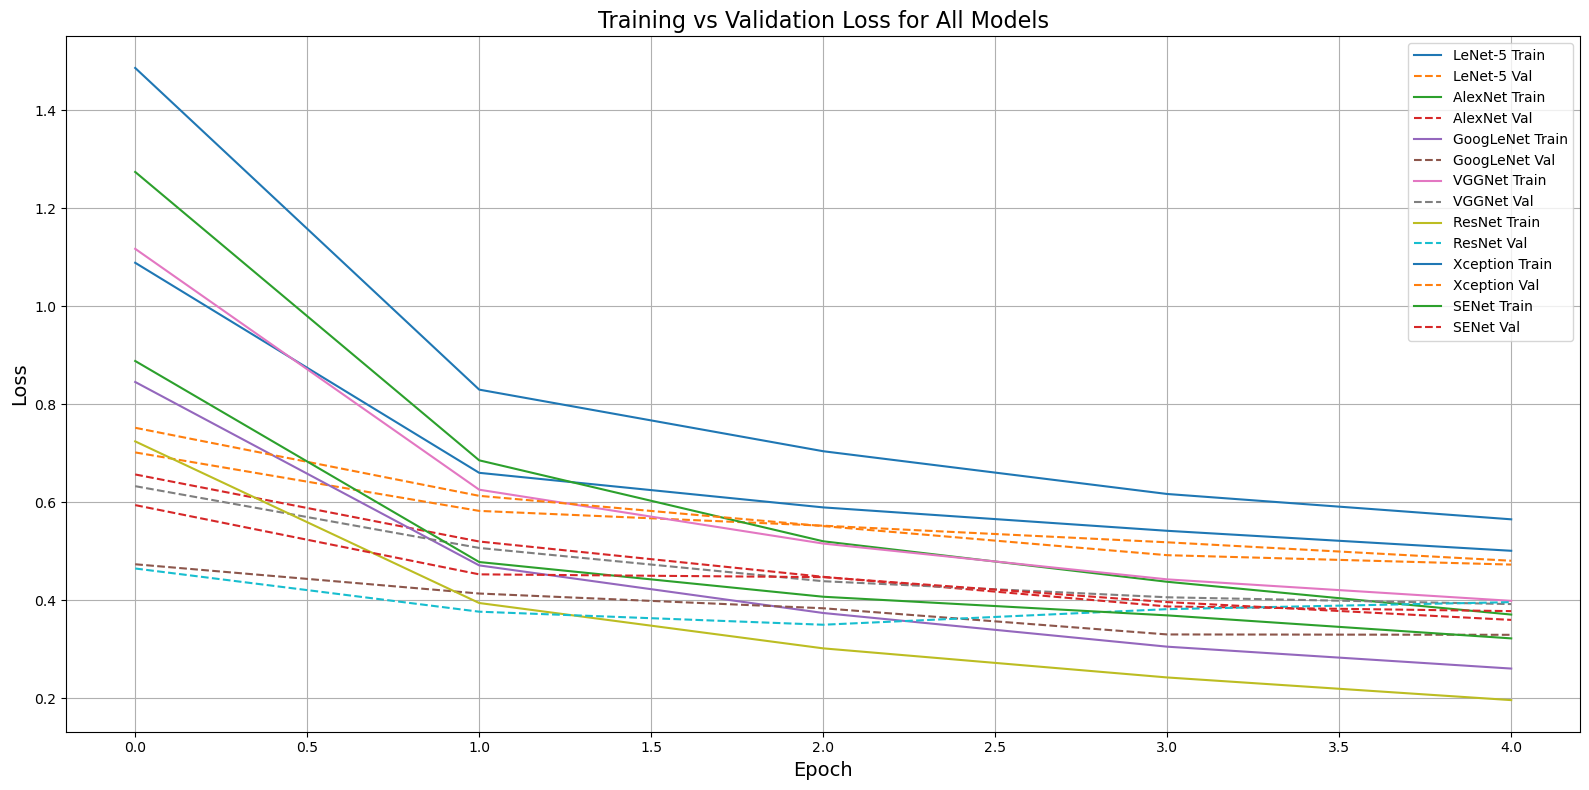

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))

for name, hist in histories.items():
    plt.plot(hist.history['loss'], label=f"{name} Train")
    plt.plot(hist.history['val_loss'], linestyle='--', label=f"{name} Val")

plt.title("Training vs Validation Loss for All Models", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


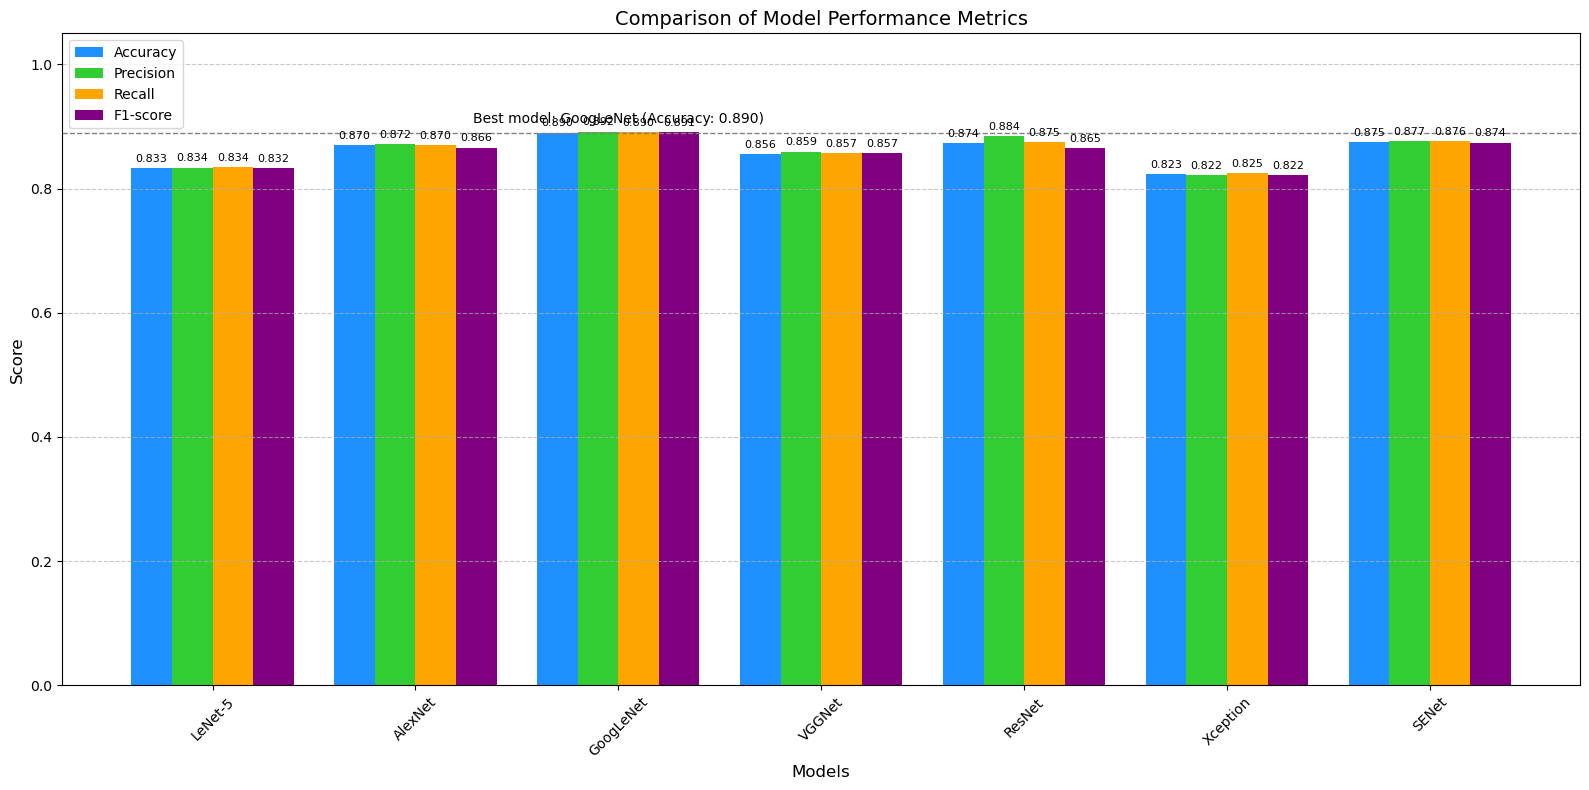

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
model_names = list(results.keys())
metric_values = {metric: [results[model][metric] for model in model_names] for metric in metrics}

x = np.arange(len(model_names))  # model index positions
width = 0.2  # bar width

# Plot
plt.figure(figsize=(16, 8))
plt.bar(x - 1.5*width, metric_values['Accuracy'], width, label='Accuracy', color='dodgerblue')
plt.bar(x - 0.5*width, metric_values['Precision'], width, label='Precision', color='limegreen')
plt.bar(x + 0.5*width, metric_values['Recall'], width, label='Recall', color='orange')
plt.bar(x + 1.5*width, metric_values['F1-score'], width, label='F1-score', color='purple')

# Add metric text labels above each bar
for i, model in enumerate(model_names):
    for j, metric in enumerate(metrics):
        plt.text(x[i] + (j - 1.5) * width,
                 metric_values[metric][i] + 0.01,
                 f"{metric_values[metric][i]:.3f}",
                 ha='center', fontsize=8)

# Highlight best accuracy model
best_model_idx = np.argmax(metric_values['Accuracy'])
best_model_name = model_names[best_model_idx]
best_accuracy = metric_values['Accuracy'][best_model_idx]
plt.axhline(best_accuracy, color='gray', linestyle='--', linewidth=1)
plt.text(best_model_idx, best_accuracy + 0.015,
         f"Best model: {best_model_name} (Accuracy: {best_accuracy:.3f})",
         ha='center', fontsize=10, color='black')

# Plot settings
plt.xticks(x, model_names, rotation=45)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Models", fontsize=12)
plt.title("Comparison of Model Performance Metrics", fontsize=14)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
